In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from ffflows.models import BaseFlow
from ffflows.utils import set_trainable
from utils import get_activation, spline_inn, coupling_flow, get_flow4flow, get_conditional_data

from nflows.distributions import StandardNormal

from ffflows.data.conditional_plane import ScienceDataset

In [2]:


base_flow_path = "/global/home/users/rrmastandrea/flows4flows/test/LHCO_no_penalty/base/epoch_99_valloss_4.862.pt"
trans_flow_path = "/global/home/users/rrmastandrea/flows4flows/test/LHCO_no_penalty_test/f4f/epoch_19_valloss_4.732.pt"


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# load in the flow

data_dim = 5
ncond = 1

# base flow params
nnodes_base = 128
nblocks_base = 15
nstack_base = 1
activation_base = "relu"
nbins_base = 10

# transfer flow params
nnodes_top = 32
nblocks_top = 8
nstack_stop = 2
nbins_top = 10
flow4flow = "delta"

base_flow = BaseFlow(spline_inn(data_dim,
                                    nnodes_base,
                                    nblocks_base,
                                    nstack_base,
                                    tail_bound=4.0,
                                    num_bins=nbins_base,
                                    context_features=ncond
                                    ),
                         StandardNormal([data_dim])
                         )
    
base_flow.load_state_dict(torch.load(base_flow_path, map_location=device))

set_trainable(base_flow, False)


    
f4flow = get_flow4flow(flow4flow,
                           coupling_flow(data_dim,
                                      nodes=nnodes_top,
                                      num_blocks=nblocks_top,
                                      num_stack=nstack_stop,
                                      tail_bound=4.0,
                                      num_bins=nbins_top,
                                      context_features=ncond,
                                      flow_for_flow=True
                                      ),
                           base_flow)
    

f4flow.load_state_dict(torch.load(trans_flow_path, map_location=device))
        
        
set_trainable(f4flow, False)
            
            

In [5]:
# generate data
"""
condition = "radial"
data = "Checkerboard"

def get_data(n_points):
        return get_conditional_data(condition, data, n_points)

dataset=get_data(1000)

plt.figure()
im = plt.scatter(dataset.data[:,0], dataset.data[:,1], c = dataset.conditions[:])
plt.colorbar(im)
plt.show()

"""


# Get training data
train_sim_data = torch.from_numpy(np.load("LHCO_data/train_sim_data.npy")).to(torch.float32)
val_sim_data = torch.from_numpy(np.load("LHCO_data/val_sim_data.npy")).to(torch.float32)
train_dat_data = torch.from_numpy(np.load("LHCO_data/train_dat_data.npy")).to(torch.float32)
val_dat_data = torch.from_numpy(np.load("LHCO_data/val_dat_data.npy")).to(torch.float32)

train_sim_cont = torch.from_numpy(np.load("LHCO_data/train_sim_cont.npy").reshape(-1, 1)).to(torch.float32)
val_sim_cont = torch.from_numpy(np.load("LHCO_data/val_sim_cont.npy").reshape(-1, 1)).to(torch.float32)
train_dat_cont = torch.from_numpy(np.load("LHCO_data/train_dat_cont.npy").reshape(-1, 1)).to(torch.float32)
val_dat_cont = torch.from_numpy(np.load("LHCO_data/val_dat_cont.npy").reshape(-1, 1)).to(torch.float32)

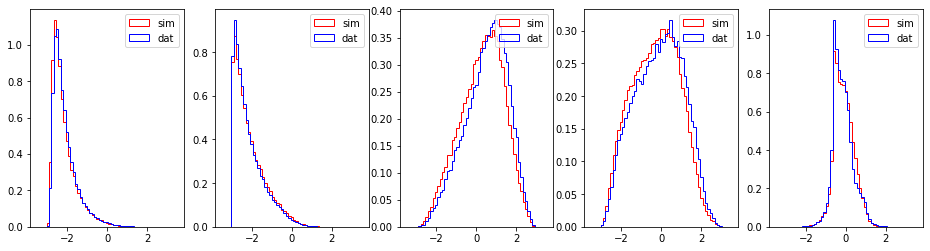

In [6]:
bins = np.linspace(-3.5, 3.5, 60)

fig, ax = plt.subplots(1, 5, figsize = (16, 4))

for i in range(data_dim):
    ax[i].hist(val_sim_data[:,i].numpy(), bins = bins, label = "sim", histtype = "step", density = True, color = "red")
    ax[i].hist(val_dat_data[:,i].numpy(), bins = bins, label = "dat", histtype = "step", density = True, color = "blue")
    
    
    ax[i].legend()
    
plt.show()

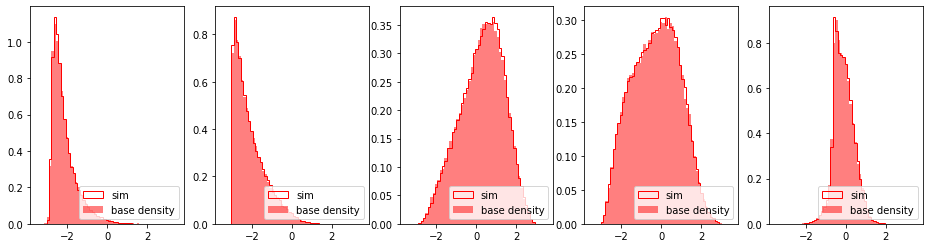

In [7]:


sim_dataset = ScienceDataset(val_sim_data, val_sim_cont)
dat_dataset = ScienceDataset(val_dat_data, val_dat_cont)


# sample from the BD
n_transform = 55753

noise = torch.normal(0, 1, size=(n_transform, 5))
bd_samples, _ = f4flow.base_flow_right._transform.inverse(noise, sim_dataset.conditions[:n_transform])

bins = np.linspace(-3.5, 3.5, 60)

fig, ax = plt.subplots(1, 5, figsize = (16, 4))
for i in range(data_dim):
    ax[i].hist(val_sim_data[:,i].numpy(), bins = bins, label = "sim", histtype = "step", density = True, color = "red")
    ax[i].hist(bd_samples[:,i].numpy(), bins = bins, label = "base density", histtype = "bar", density = True, color = "red", alpha = 0.5)
    ax[i].legend(loc = "lower right")
    
plt.show()

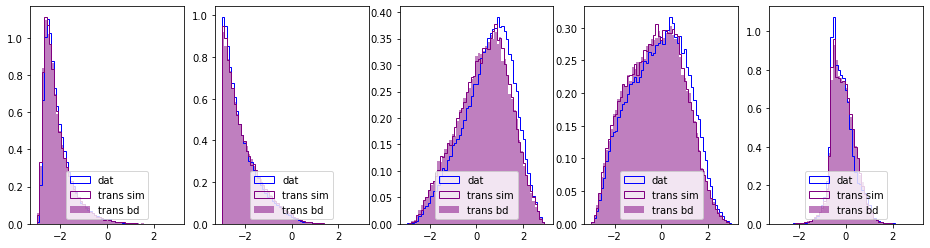

In [12]:
# transform
transformed_sim, _ = f4flow.transform(sim_dataset.data[:n_transform], sim_dataset.conditions[:n_transform], dat_dataset.conditions[:n_transform])
transformed_bd, _ = f4flow.transform(bd_samples, sim_dataset.conditions[:n_transform], dat_dataset.conditions[:n_transform])


# get summary stats

bins = np.linspace(-3, 3, 60)

fig, ax = plt.subplots(1, 5, figsize = (16, 4))
for i in range(data_dim):
    ax[i].hist(val_dat_data[:,i].numpy(), bins = bins, label = "dat", histtype = "step", density = True, color = "blue")
    ax[i].hist(transformed_sim[:,i].numpy(), bins = bins, label = "trans sim", histtype = "step", density = True, color = "purple")
    ax[i].hist(transformed_bd[:,i].numpy(), bins = bins, label = "trans bd", histtype = "bar", density = True, color = "purple", alpha = 0.5)
    ax[i].legend(loc = "lower center")
plt.show()